In [14]:
import pandas as pd

In [2]:
from keras.applications.vgg16 import VGG16
import os
from keras.layers import Flatten, Dense, AveragePooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:

learning_rate = 0.0001
img_width = 150
img_height = 150
nbr_train_samples = 3019
nbr_validation_samples = 758
nbr_epochs = 2
batch_size = 20

train_data_dir = 'new_train'
val_data_dir = 'new_valid'

fishes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

print('Loading VGG16 Weights ...')

vgg16_base = VGG16(include_top=False, weights='imagenet',
                    input_tensor=None, input_shape=(150, 150,3))
# Note that the preprocessing of InceptionV3 is:
# (x / 255 - 0.5) x 2

print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = GlobalAveragePooling2D()(output)
# let's add a fully-connected layer
output = Dense(1024, activation='relu')(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(8, activation='softmax')(output)


vgg16_model = Model(vgg16_base.input, output)
#InceptionV3_model.summary()

optimizer = SGD(lr = learning_rate, momentum = 0.9, decay = 0.0, nesterov = True)
vgg16_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        shuffle = True,
        classes = fishes,
        class_mode = 'categorical')

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        classes = fishes,
        class_mode = 'categorical')



Loading VGG16 Weights ...
Adding Average Pooling Layer and Softmax Output Layer ...
Found 3019 images belonging to 8 classes.
Found 758 images belonging to 8 classes.


In [4]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        

print("starting to fit model")
# autosave best Model
best_model_file = "./weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)


starting to fit model


In [5]:
history = vgg16_model.fit_generator(
        train_generator,
        samples_per_epoch = nbr_train_samples,
        nb_epoch = nbr_epochs,
        validation_data = validation_generator,
        nb_val_samples = nbr_validation_samples,
        callbacks = [earlystopping,best_model])

Epoch 1/2
3019/3019 [==============================] - 6166s - loss: 1.6408 - acc: 0.4323 - val_loss: 1.5198 - val_acc: 0.4749
Epoch 2/2
3019/3019 [==============================] - 6176s - loss: 1.4455 - acc: 0.5068 - val_loss: 1.3336 - val_acc: 0.5383


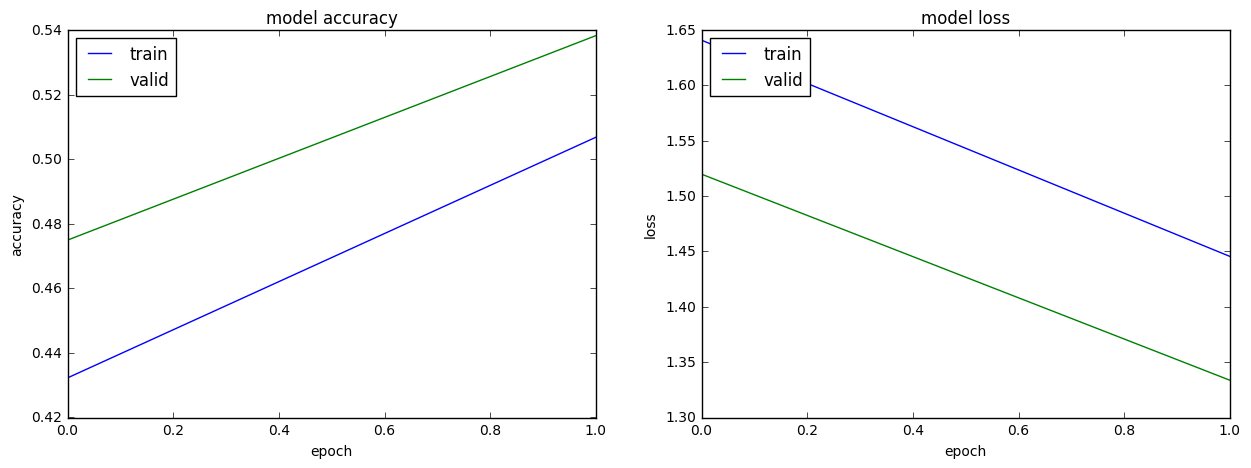

In [6]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [ ]:
test_dir = "test_stg1/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(150,150),
            batch_size=10,
            class_mode=None,
            shuffle=False)

In [ ]:
preds = vgg16_model.predict_generator(test_generator,1000)

In [11]:
preds[0]

array([ 0.31355375,  0.01711159,  0.03287278,  0.01051113,  0.44477218,
        0.01584952,  0.04502339,  0.12030563], dtype=float32)

In [12]:
clipped_preds = np.clip(preds,(1-0.82)/7,0.82)

In [16]:
submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/train/"))
test_files = os.listdir("test_stg1/test_stg1/")
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.313554,0.025714,0.032873,0.025714,0.444772,0.025714,0.045023,0.120306
1,img_00007.jpg,0.615895,0.047381,0.027842,0.025714,0.025714,0.044983,0.025714,0.207711
2,img_00009.jpg,0.669179,0.027317,0.025714,0.025714,0.097403,0.067046,0.039401,0.070989
3,img_00018.jpg,0.549258,0.025714,0.030986,0.025714,0.083362,0.057311,0.050895,0.192416
4,img_00027.jpg,0.207283,0.025714,0.032032,0.025714,0.025714,0.077042,0.148734,0.495641


In [17]:
submission.to_csv("fine_tuned_vgg_clipped.csv",index = None)